Machine Learning Stripped Helium Stars.  
--- 
By Bethany Ann Ludwig  
Theoretical Data is provided by Ylva Gotberg.  
Optical Data is from the MCPS Survey.  
UV data was created by our group with the Swift UVOT images. 


### Stripped Helium Stars are stars that have had their outer hydrogen envelope removed by a companion

![top](top.gif)

### We know that this process causes the mass loser to be hot and blue and, theoretically, should lie *bluewards of the main sequence.*

<img src="TheoryCMD.png" alt="theorycmd" width="620" height="540"/>

### Previous photometry made it difficult to create these color magnitude diagrams because of problems with clustering.

<img src="Clustering.png" alt="clustering" width="620" height="540"/>

### But with a new technique, "The Tractor", we can make a model of the sky...

<img src="Tractor.png" alt="thetractor" width="1120" height="540"/>

### and create our own photometry!

<img src="CMD.png" alt="cmd" width="1120" height="540"/>

### But what if I told you... left of ZAMS *wasn't* the best way to identify stripped helium stars.

![morpheus](morpheus.gif "whatifitoldyou")

# Stripped Helium Star Identification Using T-Distributed Stochastic Neighbor Embedding and Support Vector Classification

In [36]:
import numpy as np 
import pandas as pd 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from IPython.display import HTML
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap, MDS, SpectralEmbedding
from sklearn.decomposition import PCA
import time 

### Data Aquisition

In [2]:
# Get the photometry
theory = pd.read_csv("data2_run_Z0.002_10.txt",skiprows=0,delimiter="\s+")
theory = theory.drop(columns=['UVW2_BB_m1', 'UVW2_BB_m2', 'UVW2_spec_m1','UVW2_spec_m2', 'UVW2_spec_tot', 'UVM2_BB_m1', 'UVM2_BB_m2','UVM2_spec_m1', 'UVM2_spec_m2', 'UVM2_spec_tot',
       'UVW1_BB_m1', 'UVW1_BB_m2', 'UVW1_spec_m1', 'UVW1_spec_m2', 'UVW1_spec_tot', 'U_BB_m1', 'U_BB_m2', 'U_spec_m1', 'U_spec_m2', 'U_spec_tot', 'B_BB_m1', 'B_BB_m2',
       'B_spec_m1', 'B_spec_m2', 'B_spec_tot', 'V_BB_m1', 'V_BB_m2', 'V_spec_m1', 'V_spec_m2', 'V_spec_tot','R_BB_m1', 'R_BB_m2', 'R_spec_m1', 'R_spec_m2',
       'R_spec_tot', 'I_BB_m1', 'I_BB_m2',  'I_spec_m1', 'I_spec_m2', 'I_spec_tot', 'J_BB_m1', 'J_BB_m2', 'J_spec_m1', 'J_spec_m2', 'J_spec_tot', 'H_BB_m1', 'H_BB_m2',
       'H_BB_tot', 'H_spec_m1', 'H_spec_m2', 'H_spec_tot', 'Ks_BB_m1','Ks_BB_m2',  'Ks_spec_m1', 'Ks_spec_m2', 'Ks_spec_tot']);
theory = theory.replace([np.inf, -np.inf,'inf',''], np.nan).dropna(axis=0,how='any')

# Get the labels
labels = pd.read_csv("data1_run_Z0.002_10.txt",skiprows=0,delimiter="\s+")
labels = labels.drop(columns=['Star_state_m1', 'Star_state_m2', 'M1init', 'M2init', 'Pinit', 'M1', 'M2', 'P', 'actual_age', 'apparent_age1', 'apparent_age2', 'log_Teff_1', 'log_Teff_2', 'logg_1', 'logg_2',
       'log_R_1', 'log_R_2', 'log_L_1', 'log_L_2', 'log_abs_mdot_1', 'log_abs_mdot_2', 'XHs_1', 'XHs_2', 'XHes_1', 'XHes_2', '-', '-.1', '-.2', '-.3'])

# Merge the two datasets
data = theory.merge(labels,on="Star_ID")

# Create Numerical Labels
data["Labels"] = np.zeros(data.shape[0])
data.loc[data["Evolution"].isin(["merger_HG","merger_MS","not_interacting",'strip_CEE_HG','strip_postHG']),"Labels"] = 1
data.loc[data["Evolution"].isin([ 'strip_RLOF_MS','strip_RLOF_HG']),"Labels"] = 2

# ZAMS
ZAMS = pd.read_csv("ZAMS_Z0.002.txt",delimiter="\s+")

# Reduction 
data = data.drop(data[(data["UVM2_BB_tot"] - data["V_BB_tot"]) > 2].index).reset_index()

# Convert to Apparent
def app(mag):
    return mag + 5 *np.log10(60000/10)

# Display Data
data.head()

,index,Star_ID,UVW2_BB_tot,UVM2_BB_tot,UVW1_BB_tot,U_BB_tot,B_BB_tot,V_BB_tot,R_BB_tot,I_BB_tot,J_BB_tot,Ks_BB_tot,Evolution,Labels
0,0,34.0,-0.7240424551670565,-0.198779,-0.744748,-0.027269,0.600048,1.030981,0.735219,1.114870,-0.098463,-1.211544,strip_RLOF_HG,2.0
1,1,836.0,-6.0044163625333935,-5.583163,-6.197298,-5.704642,-5.153202,-4.792138,-5.123416,-4.787683,-6.034349,-7.147430,strip_RLOF_MS,2.0
2,2,886.0,-2.3424303501938093,-2.175755,-3.028747,-3.142772,-2.821247,-2.670700,-3.110348,-2.907072,-4.253786,-5.366867,merger_HG,1.0
3,3,1084.0,-0.7543247976414682,-0.608636,-1.491637,-1.673778,-1.382933,-1.260961,-1.715607,-1.530462,-2.890726,-4.003807,merger_HG,1.0
4,4,1272.0,-2.5693210578531605,-2.344456,-3.132661,-3.102058,-2.723024,-2.519990,-2.932319,-2.695713,-4.017156,-5.130237,merger_HG,1.0


### A first look at the data, indicates that we can simplify these labels into stripped and not stripped stars. 

Text(0.5, 0, 'UVM2 - V')

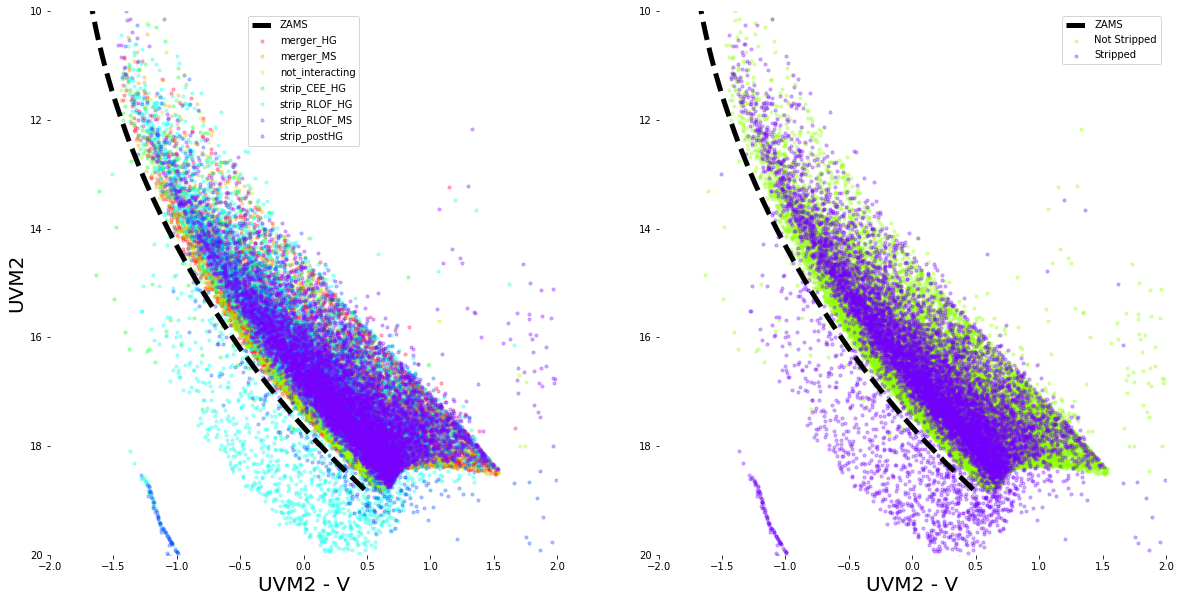

In [3]:
evolution_labels = np.unique(data.Evolution)
numerical_labels = ["Not Stripped", "Stripped"]
# Get data by all evolutionary states
UVM2_ALL = [data.loc[data["Evolution"] == state,"UVM2_BB_tot"].astype(float) for state in evolution_labels]
V_ALL = [data.loc[data["Evolution"] == state,"V_BB_tot"] for state in evolution_labels]
# Get data by stripped vs not stripped
UVM2_STRIP = [data.loc[data["Labels"] == state,"UVM2_BB_tot"].astype(float) for state in [1,2]]
V_STRIP = [data.loc[data["Labels"] == state,"V_BB_tot"] for state in [1,2]]
f, (ax,bx) = plt.subplots(1,2,figsize=(20,10))
cmap = cm.get_cmap("gist_rainbow"); twocolor = [0.3,0.85]
[ax.scatter(app(UVM2_ALL[i].values) - app(V_ALL[i].values), app(UVM2_ALL[i].values), label=evolution_labels[i],alpha=0.3 ,s=10,c=[cmap(i/7)]) for i in range(len(evolution_labels))]
[ax.spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
[bx.scatter(app(UVM2_STRIP[i].values) - app(V_STRIP[i].values), app(UVM2_STRIP[i].values), label=numerical_labels[i],alpha=0.3, c=[cmap(twocolor[i])],s=10)for i in range(len(numerical_labels))]
[bx.spines[label].set_visible(False) for label in ["top","bottom","left","right"]]

# ZAMS 
ax.plot(app(ZAMS.UVM2_BB) - app(ZAMS.V_BB),app(ZAMS.UVM2_BB),linewidth=5,c="black",label="ZAMS",linestyle="--")
bx.plot(app(ZAMS.UVM2_BB) - app(ZAMS.V_BB),app(ZAMS.UVM2_BB),linewidth=5,c="black",label="ZAMS",linestyle="--")


ax.set_ylim(20,10); bx.set_ylim(20,10)
ax.set_xlim(-2,2); bx.set_xlim(-2,2)
ax.legend(); bx.legend()
ax.set_ylabel("UVM2",fontsize=20)
ax.set_xlabel("UVM2 - V",fontsize=20); bx.set_xlabel("UVM2 - V",fontsize=20)
#plt.ylim(3,-7)

### Separating distinct groups by eye, isn't easy. 

[None, None]

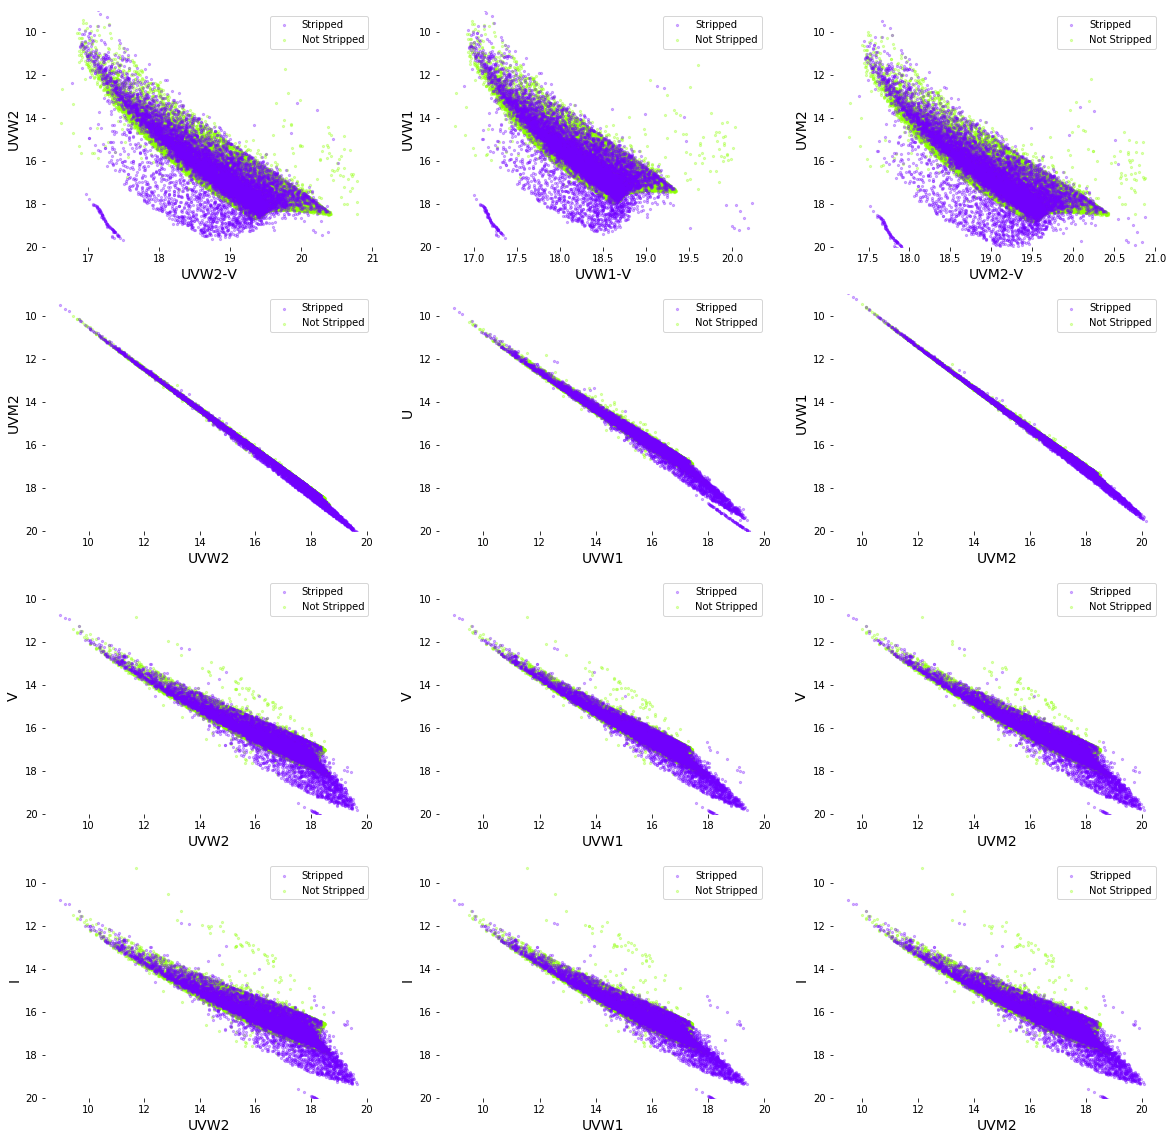

In [4]:
stripped = data.loc[data["Labels"] == 2]
notstripped = data.loc[data["Labels"] == 1]

def plot(axis,X,Y,Xlabel,Ylabel,Stripped):
    if Stripped:
        axis.scatter(app(X),app(Y),c=[cmap(twocolor[1])], s=5,alpha=0.3,label="Stripped",zorder=1)
    else:
        axis.scatter(app(X),app(Y),c=[cmap(twocolor[0])], s=5,alpha=0.3,label="Not Stripped",zorder=0)

    #axis.set_ylim(axis.get_ylim()[::-1])
    [axis.spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
    axis.set_ylim(20,9)
    axis.set_ylabel(Ylabel,fontsize=14); axis.set_xlabel(Xlabel,fontsize=14)
    axis.legend()
    

f, axes = plt.subplots(4,3,figsize=(20,20))

[plot(axes[0,0],df["UVW2_BB_tot"].astype(float) - df["V_BB_tot"],df["UVW2_BB_tot"].astype(float),"UVW2-V","UVW2",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[0,1],df["UVW1_BB_tot"].astype(float) - df["V_BB_tot"],df["UVW1_BB_tot"].astype(float),"UVW1-V","UVW1",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[0,2],df["UVM2_BB_tot"].astype(float) - df["V_BB_tot"],df["UVM2_BB_tot"].astype(float),"UVM2-V","UVM2",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[1,0],df["UVW2_BB_tot"].astype(float),df["UVM2_BB_tot"].astype(float),"UVW2","UVM2",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[1,1],df["UVW1_BB_tot"].astype(float),df["U_BB_tot"].astype(float),"UVW1","U",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[1,2],df["UVM2_BB_tot"].astype(float),df["UVW1_BB_tot"].astype(float),"UVM2","UVW1",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[2,0],df["UVW2_BB_tot"].astype(float),df["V_BB_tot"].astype(float),"UVW2","V",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[2,1],df["UVW1_BB_tot"].astype(float),df["V_BB_tot"].astype(float),"UVW1","V",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[2,2],df["UVM2_BB_tot"].astype(float),df["V_BB_tot"].astype(float),"UVM2","V",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[3,0],df["UVW2_BB_tot"].astype(float),df["I_BB_tot"].astype(float),"UVW2","I",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[3,1],df["UVW1_BB_tot"].astype(float),df["I_BB_tot"].astype(float),"UVW1","I",condition) for condition, df in zip([True,False],[stripped,notstripped])]

[plot(axes[3,2],df["UVM2_BB_tot"].astype(float),df["I_BB_tot"].astype(float),"UVM2","I",condition) for condition, df in zip([True,False],[stripped,notstripped])]


## Dimensionality Reduction with t-SNE - All Data

In [5]:
X = data[['UVW2_BB_tot', 'UVM2_BB_tot', 'UVW1_BB_tot',
       'U_BB_tot', 'B_BB_tot', 'V_BB_tot', 'R_BB_tot', 'I_BB_tot', 'J_BB_tot',
       'Ks_BB_tot']]
print(X.shape)

(34575, 10)


### Increasing perplexity increases the tendency towards clearer shapes.

In [6]:
start = time.time()
X_embedded = [TSNE(n_components = 2, perplexity = perplex, init = 'random', random_state=0).fit_transform(X) for perplex in [30,50,100,150]]
print("Time Taken:" + str(time.time() - start)+" s")

Time Taken:2086.231213569641 s


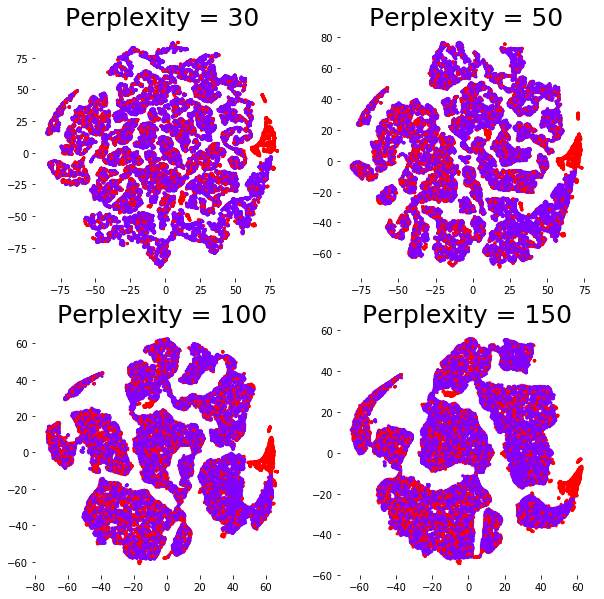

In [19]:
f, axes = plt.subplots(2,2,figsize=(10,10))
counter = 0 ; perplexity = [30,50,100,150]
for i in np.arange(2):
    for j in np.arange(2):
        axes[i,j].scatter(X_embedded[counter][:,0],X_embedded[counter][:,1],c=data["Labels"],s=5,cmap="rainbow")
        axes[i,j].set_title("Perplexity = " + str(perplexity[counter]),fontsize=25)
        [axes[i,j].spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
        counter += 1

In [20]:
start = time.time()
X_embedded = [TSNE(n_components = 2, perplexity = perplex, init = 'random', random_state=0).fit_transform(X) for perplex in [5]]
print("Time Taken:" + str(time.time() - start)+" s")

Time Taken:349.14531350135803 s


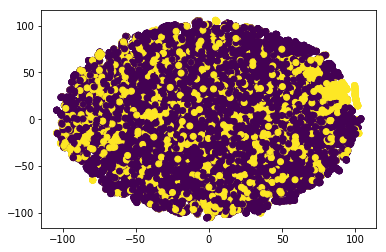

In [24]:
plt.scatter(X_embedded[0][:,0],X_embedded[0][:,1],c=data["Labels"],s=5)

## Dimensionality Reduction with t-SNE - Running PCA First

In [26]:
pca = PCA(n_components = 2)
pca.fit(X)
X_reduced = pca.transform(X)
comp = pca.components_
print(X_reduced.shape)

(34575, 2)


[None, None, None, None]

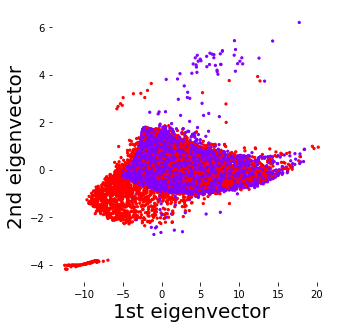

In [29]:
cmap="rainbow"

fig = plt.figure(1, figsize=(5, 5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=data["Labels"],cmap=cmap,s=5)
ax.set_xlabel("1st eigenvector",fontsize=20)
ax.set_ylabel("2nd eigenvector",fontsize=20)
ax.set_facecolor('white')
[ax.spines[label].set_visible(False) for label in ["top","bottom","left","right"]]

In [30]:
start = time.time()
X_embed_reduc = [TSNE(n_components = 2, perplexity = perplex, init = 'random', random_state=0).fit_transform(X_reduced) for perplex in [30,50,100,150]]
print("Time Taken:" + str(time.time() - start)+" s")

Time Taken:2031.279291152954 s


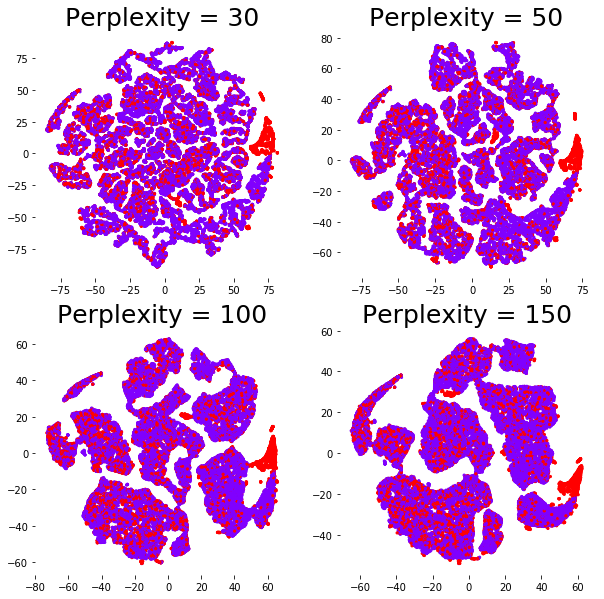

In [32]:
f, axes = plt.subplots(2,2,figsize=(10,10))
counter = 0 ; perplexity = [30,50,100,150]
for i in np.arange(2):
    for j in np.arange(2):
        axes[i,j].scatter(X_embed_reduc[counter][:,0],X_embed_reduc[counter][:,1],c=data["Labels"],s=5,cmap="rainbow")
        axes[i,j].set_title("Perplexity = " + str(perplexity[counter]),fontsize=25)
        [axes[i,j].spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
        counter += 1

## Dimensionality Reduction with other manifold learning methods

In [33]:
neighbors = 10

#### Linear Embedded Manifold Learning

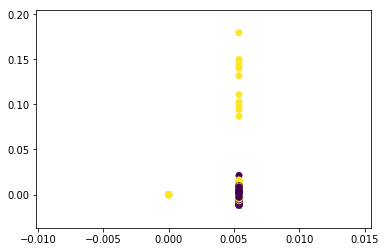

In [47]:
plt.scatter(trans_st[0],trans_st[1],c=data["Labels"])

In [40]:
# Locally Linear Embedding Manifold learning
LLE_methods = ['standard','ltsa','hessian','modified']

trans_st = LocallyLinearEmbedding(n_neighbors = neighbors, n_components = 2, method = LLE_methods[0]).fit_transform(X).T
#trans_ltsa = LocallyLinearEmbedding(n_neighbors = neighbors, n_components = 2, method = LLE_methods[1]).fit_transform(X).T
#trans_hes = LocallyLinearEmbedding(n_neighbors = neighbors, n_components = 2, method = LLE_methods[2]).fit_transform(X).T
#trans_mod = LocallyLinearEmbedding(n_neighbors = neighbors, n_components = 2, method = LLE_methods[3]).fit_transform(X).T

# f, axes = plt.subplots(2,2,figsize=(10,10))
# counter = 0 ;
# for i in np.arange(2):
#     for j in np.arange(2):
#         axes[i,j].scatter(trans[counter][0],trans[counter][1],c=data["Labels"],s=5,cmap="rainbow")
#         axes[i,j].set_title(LLE_methods[counter],fontsize=25)
#         [axes[i,j].spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
#         counter += 1

C:\Users\Betha\Anaconda3\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:931: LinAlgWarning: Diagonal number 672 is exactly zero. Singular matrix.
  self.M_lu = lu_factor(M)


ValueError: Error in determining null-space with ARPACK. Error message: 'ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. '. Note that method='arpack' can fail when the weight matrix is singular or otherwise ill-behaved.  method='dense' is recommended. See online documentation for more information.

### Isomap Manifold Learning

In [48]:
trans_iso = Isomap(n_neighbors=neighbors,n_components = 2).fit_transform(X).T

f, axes = plt.subplots(2,2,figsize=(10,10))
counter = 0 ;
for i in np.arange(2):
    for j in np.arange(2):
        axes[i,j].scatter(trans_iso[counter][0],trans_iso[counter][1],c=data["Labels"],s=5,cmap="rainbow")
        axes[i,j].set_title(LLE_methods[counter],fontsize=25)
        [axes[i,j].spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
        counter += 1

MemoryError: 

### Multi-dimensional scaling

In [50]:
trans_mds = MDS(n_components = 2).fit_transform(X).T

f, axes = plt.subplots(2,2,figsize=(10,10))
counter = 0 ;
for i in np.arange(2):
    for j in np.arange(2):
        axes[i,j].scatter(trans_mds[counter][0],trans_mds[counter][1],c=data["Labels"],s=5,cmap="rainbow")
        axes[i,j].set_title(LLE_methods[counter],fontsize=25)
        [axes[i,j].spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
        counter += 1

MemoryError: 

### Spectral Embedding

C:\Users\Betha\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


ValueError: 'c' argument has 34575 elements, which is not acceptable for use with 'x' with size 1, 'y' with size 1.

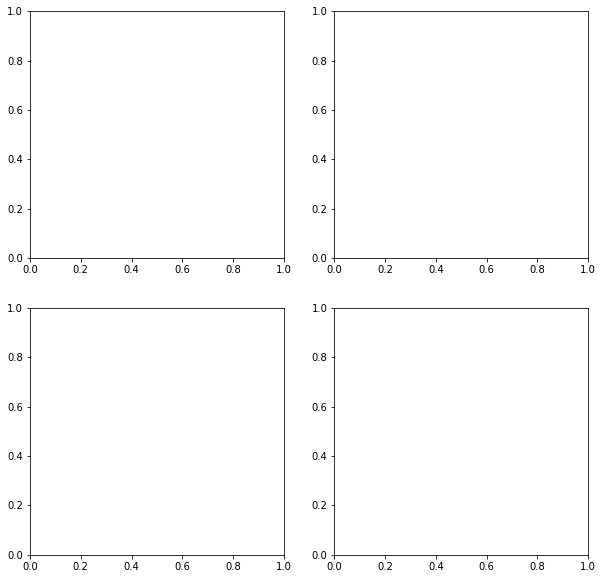

In [51]:
trans_spec = SpectralEmbedding(n_neighbors=neighbors,n_components = 2).fit_transform(X).T

f, axes = plt.subplots(2,2,figsize=(10,10))
counter = 0 ;
for i in np.arange(2):
    for j in np.arange(2):
        axes[i,j].scatter(trans_spec[counter][0],trans_spec[counter][1],c=data["Labels"],s=5,cmap="rainbow")
        axes[i,j].set_title(LLE_methods[counter],fontsize=25)
        [axes[i,j].spines[label].set_visible(False) for label in ["top","bottom","left","right"]]
        counter += 1